In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### Подготовка данных 

Мы используем данные, полученные во время медосмотра.

Наша __цель__ - обработать и визуализировать данные, чтобы понять, какие факторы могут влиять на наличие сердечно-сосудистых заболеваний (ССЗ).

Мы начинаем с подготовки датасета:
- проверяем наличие пустых значений
- изменяем шкалу уровней глюкозы и холестерола: в оригинальных данных 1 обозначает нормальный уровень, 2 - уровень выше нормы, 3 - уровень значительно выше нормы. Мы меняем систему на бинарную: 0 - норма, 1 - выше нормы
- смотрим на описательные статистики, чтобы заметить возможные выбросы
- очищаем данные: удаляем те, где
    - систолическое давление ниже диастолического;
    - артериальное давление отрицательное;
    - артериальное давление, рост и вес ниже 0.025- или выше 0.975-процентиля
- добавляем столбцы:
    - BMI (индекс массы тела)
    - age_years (делим возраст в днях на 365.25, чтобы учесть високосные года)
    - ap_mean (среднее артериальное давление, рассчитываемое в медицине как ap_lo + (ap_hi - ap_lo) / 3))

In [2]:
df = pd.read_csv('data/medical_examination.csv')
df.head()

,id,age,sex,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [3]:
df.isna().any()

id             False
age            False
sex            False
height         False
weight         False
ap_hi          False
ap_lo          False
cholesterol    False
gluc           False
smoke          False
alco           False
active         False
cardio         False
dtype: bool

In [4]:
df.describe()

,id,age,sex,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349843,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.477253,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,3.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
df = df[
        (df['ap_lo'] <= df['ap_hi']) &
        (df['ap_lo'] > 0) &
        (df['ap_hi'] > 0) & 
        (df['ap_lo'].quantile(0.975) >= df['ap_lo']) &
        (df['ap_lo'] >= df['ap_lo'].quantile(0.025)) &
        (df['ap_hi'].quantile(0.975) >= df['ap_hi']) &
        (df['ap_hi'] >= df['ap_hi'].quantile(0.025)) &
        (df['height'].quantile(0.975) >= df['height']) &
        (df['height'] >= df['height'].quantile(0.025)) &
        (df['weight'].quantile(0.975) >= df['weight']) &
        (df['weight'] >= df['weight'].quantile(0.025))
       ]
df['BMI'] = df['weight'] * 10000 / (df['height']**2)
df['overweight'] = np.where(df['BMI'] > 25, 1, 0)
df['cholesterol'] = np.where(df['cholesterol'] > 1, 1, 0)
df['gluc'] = np.where(df['gluc'] > 1, 1, 0)
df['age_years'] = df.age / 365.25
df['ap_mean'] = round(df.ap_lo + (df.ap_hi - df.ap_lo) / 3)

### Визуализация данных

- визуализируем бинарные качественные переменные с помощью catplot, перестроив для удобства датафрейм
- визуализируем количественные переменные с помощью kdeplot (графика плотностей)
- строим матрицу корреляции, чтобы выявить возможные взаимосвязи

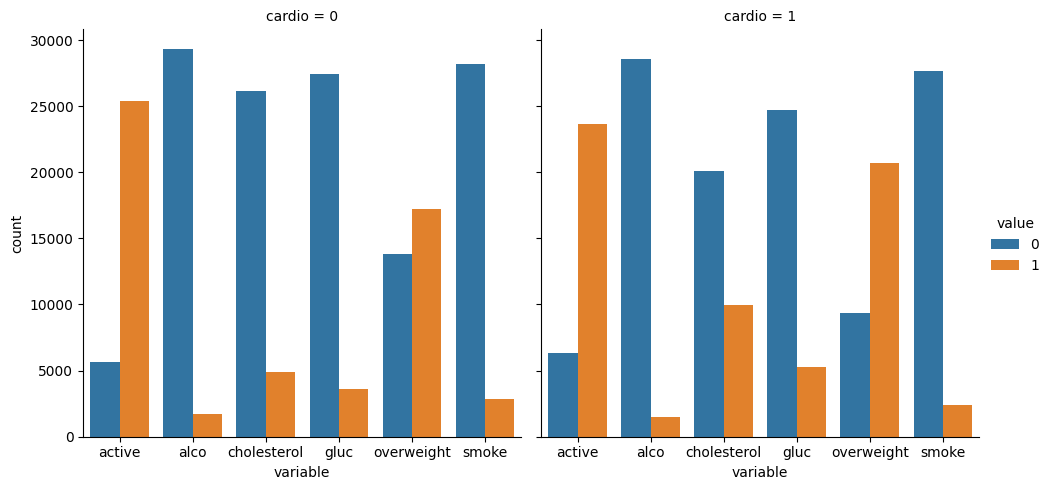

In [6]:
df_cat = df.melt(
    'cardio', ('active', 'alco', 'cholesterol', 'gluc', 'overweight', 'smoke'))

  # Draw the catplot with 'sns.catplot()'
sns.catplot(kind='count',
            data=df_cat,
            x='variable',
            hue='value',
            col='cardio')


- __Повышенный уровень холестерина и BMI > 25 чаще наблюдается среди людей с ССЗ__
- __Повышенный уровень глюкозы также встречается чуть чаще__

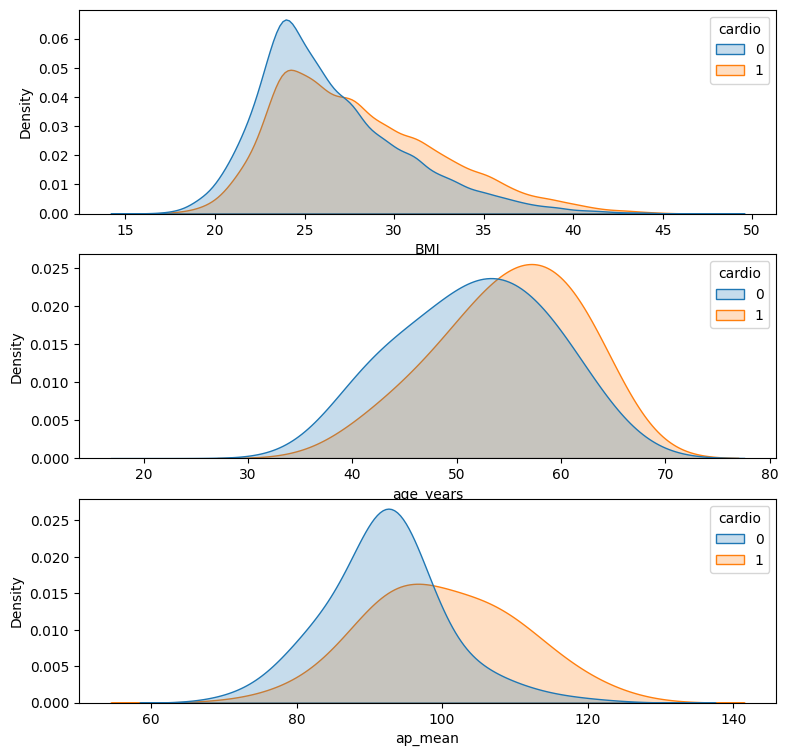

In [7]:
fig, (ax1, ax2, ax3,) = plt.subplots(3, figsize = (9, 9))

sns.kdeplot(df, 
           x = 'BMI',
           hue = 'cardio',
           fill = True,
           ax = ax1)

sns.kdeplot(df, 
           x = 'age_years',
           hue = 'cardio',
           bw_adjust = 5,
           fill = True,
           ax = ax2)

sns.kdeplot(df, 
           x = 'ap_mean',
           hue = 'cardio',
           bw_adjust = 5,
           fill = True,
           ax = ax3)

plt.show()

- __Для всех переменных распределение людей с ССЗ смещено вправо по сравнению с людьми без ССЗ__
- __Самая большая разница в форме распределений наблюдается для среднего артериального давления__

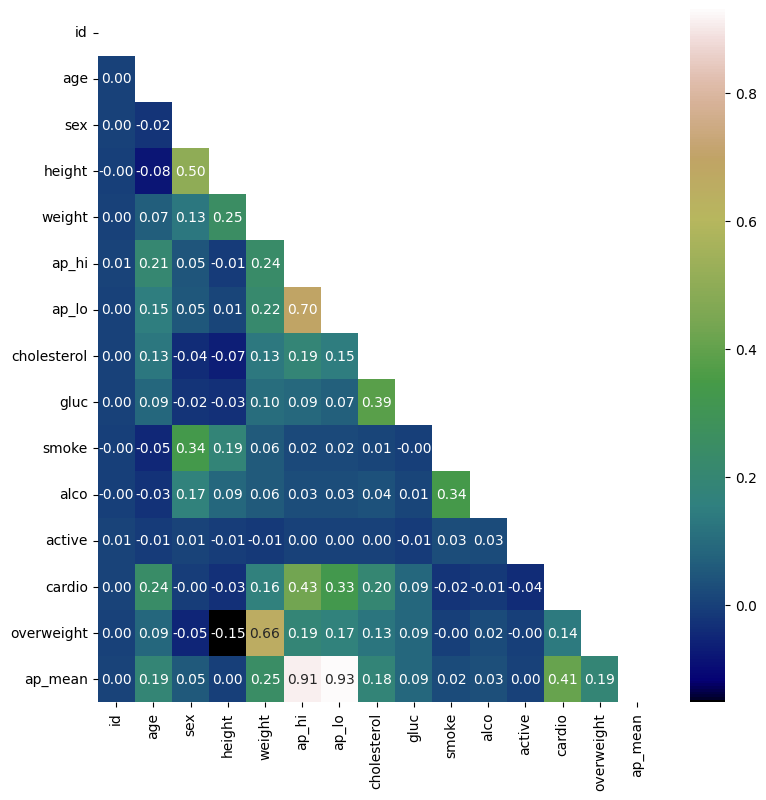

In [8]:
corr = df.drop(['BMI', 'age_years'], axis = 1).corr()
mask = np.tril(np.ones(corr.shape), -1).astype(bool) # Generate a mask to only get lower triangle

fig, ax = plt.subplots(figsize = (9, 9))
sns.heatmap(corr.where(mask),
          ax=ax,
          annot=True,
          cmap='gist_earth',
          fmt=".2f")
plt.show()

Ряд высоких коэффициентов корелляции в нашей матрице обусловлен очевидными взаимосвязями между переменными (например, среднее и систолическое артериальное давление, или рост и пол). Корелляцию между этими переменными мы не рассматриваем.

- __Коэффициент корелляции > 0.4:__
    - наличие ССЗ и среднее артериальное давление (0.41)
    - наличие ССЗ и систолическое артериальное давление (0.43)
- __Коэффициент корелляции > 0.3:__
    - повышенный уровень холестерола и повышенный уровень глюкозы (0.39)
    - наличие ССЗ и диастолическое артериальное давление (0.33)
- __Коэффициент корелляции > 0.2:__
    - вес и артериальное давление (0.25)
    - наличие ССЗ и возраст (0.24)
 
Кроме того, есть определённая корелляция между курением и полом (0.34) и курением и употреблением алкоголя (0.34).